<a href="https://colab.research.google.com/github/dercodeKoenig/colab-KI/blob/main/xt_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir /root/.kaggle/
!echo '{"username":"bpwqsdd","key":"55c6bac7a9ea2f38dd966a1d1a4e31f8"}' > /root/.kaggle/kaggle.json
!pip uninstall kaggle -y
!python -m pip install kaggle

Found existing installation: kaggle 1.5.12
Uninstalling kaggle-1.5.12:
  Successfully uninstalled kaggle-1.5.12
     |████████████████████████████████| 58 kB 3.2 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=345831f8abaef7876b414b7e8528438efe2ddc6125add30ab4116260279f454f
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle


In [ ]:
!kaggle datasets download -d bpwqsdd/curent-candles-eurusd
!unzip curent-candles-eurusd.zip

  0% 0.00/140k [00:00<?, ?B/s]
100% 140k/140k [00:00<00:00, 47.6MB/s]
Archive:  curent-candles-eurusd.zip
  inflating: current_data.csv        


In [ ]:
!pip install ta
import time
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd    
import numpy as np
import datetime
import math
from IPython.display import clear_output
import ta
from tqdm import tqdm
import gc


In [ ]:
symbol = "EURUSD"
seq_len = int(24*20)
lookfuture = int(24*2)
atr_mult = 4
stop_loss_mult = 0.1
train_window = 64
sample_weight = 2

In [ ]:
df = pd.read_csv("current_data.csv")
df

,Unnamed: 0,time,Open,High,Low,Close
0,0,1633992300,1.15563,1.15571,1.15500,1.15500
1,1,1633993200,1.15499,1.15510,1.15494,1.15503
2,2,1633994100,1.15503,1.15534,1.15486,1.15534
3,3,1633995000,1.15534,1.15540,1.15523,1.15532
4,4,1633995900,1.15532,1.15543,1.15504,1.15504
...,...,...,...,...,...,...
9995,9995,1646433900,1.09248,1.09358,1.09195,1.09337
9996,9996,1646434800,1.09339,1.09344,1.09299,1.09307
9997,9997,1646435700,1.09307,1.09323,1.09268,1.09284
9998,9998,1646436600,1.09285,1.09357,1.09249,1.09353


In [ ]:
class candle_class:
    t = 0
    o = 0
    h = 0
    l = 0
    c = 0
    sma21 = 0
    sma50 = 0
    sma200 = 0
    rsi14 = 0
    rsi21 = 0
    atr_value = 0
    
    action = -1
    candles_past = 0
    
    validated = False
    generated = False
    
class manager:
    candles = []
    name = ""
    current_candle_time = 0
    model = 0
    
    def save_state(self):
        self.model.save(self.name)
        file = open(self.name+"_candle_time.txt", "w")
        file.write(str(self.current_candle_time))
        file.close()
        
    def create_model(self):
        self.model = self.make_model()
        self.model.summary()
    
    def restore(self):
        self.model = tf.keras.models.load_model(self.name)
        file = open(self.name+"_candle_time.txt", "r")
        text = file.read()
        file.close()
        self.current_candle_time = float(text)
        print("resume training from", self.current_candle_time)
    
    def __init__(self, name):
        self.name = name
    
    def make_model(self):
        inputs = tf.keras.layers.Input(shape = (seq_len, 8))
        x = inputs
    
        x = tf.keras.layers.Conv1D(64,3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=0.005))(x)
        tf.keras.layers.LeakyReLU(alpha=0.2)(x)
        x = tf.keras.layers.LSTM(32, activation = "tanh", return_sequences=True, kernel_regularizer=tf.keras.regularizers.L2(l2=0.005))(x)
        
        x = tf.keras.layers.Conv1D(64,3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=0.005))(x)
        tf.keras.layers.LeakyReLU(alpha=0.2)(x)
        x = tf.keras.layers.LSTM(32, activation = "tanh", return_sequences=True, kernel_regularizer=tf.keras.regularizers.L2(l2=0.005))(x)

        x = tf.keras.layers.GRU(32, activation = "tanh", return_sequences=False, kernel_regularizer=tf.keras.regularizers.L2(l2=0.005))(x)
    
        x = tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(l2=0.005))(x)
        x = tf.keras.layers.Dense(16, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(l2=0.005))(x)
        outputs = tf.keras.layers.Dense(3, activation = "softmax", kernel_regularizer=tf.keras.regularizers.L2(l2=0.005))(x)
        
        model = tf.keras.Model(inputs, outputs)
    
        loss = tf.keras.losses.SparseCategoricalCrossentropy()
        opt = tf.keras.optimizers.SGD(learning_rate=0.0005, momentum=0.95, nesterov=True)
        #opt = tf.keras.optimizers.Adam(learning_rate=0.00005)
        model.compile(opt, loss, metrics="accuracy")
        return model
        
    
    def candles_to_dataframe(self, candles):
        o = [x.o for x in candles]
        h = [x.h for x in candles]
        l = [x.l for x in candles]
        c = [x.c for x in candles]
        data = {"Open":o, "High":h, "Low":l, "Close":c}
        df = pd.DataFrame(data)
        return df
    
    def get_current_validated_candles(self):
        if len(self.candles) < lookfuture + seq_len + train_window + 200:
            return None
        vc = self.candles[-lookfuture-seq_len-train_window:-lookfuture]
        
        return vc
    
    
    def add_new_candle(self, t,o,h,l,c):
        for i in range(len(self.candles)):
            self.candles[i].candles_past+=1
            
        new_candle = candle_class()
        new_candle.t = t
        new_candle.o = o
        new_candle.h = h
        new_candle.l = l
        new_candle.c = c
        self.candles.append(new_candle)
        
        if len(self.candles) >= 200:
            
            df = self.candles_to_dataframe(self.candles[-21:])
            sma21_raw = list(ta.trend.SMAIndicator(df["Close"], 21).sma_indicator())[-1]
            
            df = self.candles_to_dataframe(self.candles[-50:])
            sma50_raw = list(ta.trend.SMAIndicator(df["Close"], 50).sma_indicator())[-1]
            
            df = self.candles_to_dataframe(self.candles[-200:])
            sma200_raw = list(ta.trend.SMAIndicator(df["Close"], 200).sma_indicator())[-1]
            
            df = self.candles_to_dataframe(self.candles[-14:])
            rsi_14 = list(ta.momentum.RSIIndicator(df["Close"], 14).rsi())[-1] / 50 - 1
        
            df = self.candles_to_dataframe(self.candles[-21:])
            rsi_21 = list(ta.momentum.RSIIndicator(df["Close"], 21).rsi())[-1] / 50 - 1
            
            df = self.candles_to_dataframe(self.candles[-200:])
            atr_value = list(ta.volatility.AverageTrueRange(df["High"], df["Low"], df["Close"], 200).average_true_range())[-1]
            
            new_candle.sma21 = sma21_raw
            new_candle.sma50 = sma50_raw
            new_candle.sma200 = sma200_raw
            new_candle.rsi14 = rsi_14
            new_candle.rsi21 = rsi_21
            new_candle.atr_value = atr_value
            new_candle.generated = True
            
            self.candles[-1] = new_candle
            
        
        
        if len(self.candles) >= lookfuture:
            to_validate = self.candles[-lookfuture]
            
            action_to_take = 0
            
            long_stop_out = False
            stop_up_long = to_validate.c + to_validate.atr_value * atr_mult
            stop_down_long = to_validate.c - to_validate.atr_value * atr_mult * stop_loss_mult
            
            short_stop_out = False
            stop_up_short = to_validate.c + to_validate.atr_value * atr_mult * stop_loss_mult
            stop_down_short = to_validate.c - to_validate.atr_value * atr_mult
            
            for i in range(-lookfuture+1, 0):
                high = self.candles[i].h
                low = self.candles[i].l
                
                if low < stop_down_long:
                    long_stop_out = True
                if high > stop_up_short:
                    short_stop_out = True
                    
                if low < stop_down_short and not short_stop_out:
                    action_to_take = 1
                    break
                
                if high > stop_up_long and not long_stop_out:
                    action_to_take = 2
                    break
                
                if short_stop_out and long_stop_out:
                    break
                
            self.candles[-lookfuture].action = action_to_take
                    
        if len(self.candles) > lookfuture + seq_len + train_window + 200:
            del self.candles[0]
        
        if self.current_candle_time < t:
            self.update_model()
            self.current_candle_time = t
        
        
    def sample_to_x_y(self, sample):
        
                current_close = sample[-1].c

                prev_close = [candle.c for candle in sample]
                prev_high = [candle.h for candle in sample]
                prev_low = [candle.l for candle in sample]

                prev_sma21 = [candle.sma21 for candle in sample]
                prev_sma50 = [candle.sma50 for candle in sample]
                prev_sma200 = [candle.sma200 for candle in sample]

                prev_sma21_relative = [-(current_close - prev_sma21[o]) / prev_sma21[o] for o in range(seq_len)]
                prev_sma50_relative = [-(current_close - prev_sma50[o]) / prev_sma50[o] for o in range(seq_len)]
                prev_sma200_relative = [-(current_close - prev_sma200[o]) / prev_sma200[o] for o in range(seq_len)]

                prev_close_relative = [-(current_close - prev_close[o]) / prev_close[o] for o in range(seq_len)]
                prev_high_relative = [-(current_close - prev_high[o]) / prev_high[o] for o in range(seq_len)]
                prev_low_relative = [-(current_close - prev_low[o]) / prev_low[o] for o in range(seq_len)]

                maxval = max(prev_high_relative)
                minval = min(prev_low_relative)
                scale = 1 / (maxval - minval)

                prev_sma21_relative_scaled = [i * scale for i in prev_sma21_relative]
                prev_sma50_relative_scaled = [i * scale for i in prev_sma50_relative]
                prev_sma200_relative_scaled = [i * scale for i in prev_sma200_relative]

                prev_close_relative_scaled = [i * scale for i in prev_close_relative]
                prev_low_relative_scaled = [i * scale for i in prev_low_relative]
                prev_high_relative_scaled = [i * scale for i in prev_high_relative]

                prev_rsi_14 = [candle.rsi14 for candle in sample]
                prev_rsi_21 = [candle.rsi21 for candle in sample]


                x = []
                for o in range(len(prev_close)):
                    ts = []
                    ts.append(prev_close_relative_scaled[o])
                    ts.append(prev_high_relative_scaled[o])
                    ts.append(prev_low_relative_scaled[o])

                    ts.append(prev_sma21_relative_scaled[o])
                    ts.append(prev_sma50_relative_scaled[o])
                    ts.append(prev_sma200_relative_scaled[o])

                    ts.append(prev_rsi_14[o])
                    ts.append(prev_rsi_21[o])

                    x.append(ts)

                x = np.array(x)
                return x
        
    def get_current_inference_data(self):
            sample = self.candles[-seq_len:]
            inference_data = self.sample_to_x_y(sample)
            return inference_data
            
    def get_current_train_samples(self):
            cvc = self.get_current_validated_candles()
            if cvc == None:
                return None
            
            samples = []
            for i in range(train_window):
                sample_candles = cvc[i:i+seq_len]
                samples.append(sample_candles)

            train_ready_samples = []
            train_ready_labels = []

            for sample in samples:
                x = self.sample_to_x_y(sample)
                train_ready_samples.append(x)
                train_ready_labels.append(sample[-1].action)
                    
            train_ready_samples = np.array(train_ready_samples)
            train_ready_labels = np.array(train_ready_labels)
                
            return train_ready_samples, train_ready_labels

    def update_model(self):
        ret = self.get_current_train_samples()
        if ret != None:
            X, Y = ret
            self.model.fit(X, Y, batch_size = 8, shuffle = False, verbose = 0)
    
    def get_current_decision(self):
        if len(self.candles) < seq_len+200 or self.candles[-1].t != self.current_candle_time:
            return None
        inference_data = self.get_current_inference_data()
        inference_data = np.reshape(inference_data, (1, seq_len, -1))
        ri = self.model(inference_data)[0]
        result = np.argmax(ri)
        return result

In [ ]:
data_manager = manager("EUR_USD_MANAGER")
data_manager.create_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 480, 8)]          0         
                                                                 
 conv1d (Conv1D)             (None, 480, 64)           1600      
                                                                 
 lstm (LSTM)                 (None, 480, 32)           12416     
                                                                 
 conv1d_1 (Conv1D)           (None, 480, 64)           6208      
                                                                 
 lstm_1 (LSTM)               (None, 480, 32)           12416     
                                                                 
 gru (GRU)                   (None, 32)                6336      
                                                                 
 dense (Dense)               (None, 32)                1056  

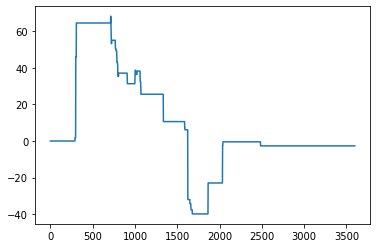

wins: 68   loss: 113   wwl: 11.5   total: -2.6613804645002554


In [ ]:
positions = []
wins = 0
losses = 0
total = 0
balance = 100
cash_list = []
stt = 5
pretrain = 1000
for i in range(len(df)):
    candle = df.iloc[i]
    _, _, o, h, l, c = candle
    data_manager.add_new_candle(i,o,h,l,c)
    result = data_manager.get_current_decision()
    if result != None and i > pretrain:
        current_candle = data_manager.candles[-1]
        while True:
            sth = False
            for o in range(len(positions)):
                ls = 1 if positions[o][3] == "LONG" else -1

                win_percent = 0
                if current_candle.h > positions[o][1]:
                    win_percent = (positions[o][1] - positions[o][0]) / positions[o][0] * positions[o][4]


                if current_candle.l < positions[o][2]:
                    win_percent = (positions[o][2] - positions[o][0]) / positions[o][0] * positions[o][4]


                win_percent*=ls


                if win_percent != 0:
                    sth = True
                    total+=win_percent - 0.015 / 100 * positions[o][4]
                    if win_percent > 0: wins+=1
                    if win_percent < 0: losses+=1
                    #print(positions[o][3], "closed for", win_percent, "% win")
                    #print("wins:", wins, "  loss:", losses, "  total:", total)
                    del positions[o]
                    break

            if not sth:
                break


        cash_list.append(total)

        atr = current_candle.atr_value
        close = current_candle.c
        
        #risk 1 % 
        order_value = (close / (atr * atr_mult * stop_loss_mult*stt)) * 0.01 * balance
        
        if result == 1:#short
            stop_up = close + atr * atr_mult * stop_loss_mult*stt
            stop_down = close - atr * atr_mult
            positions.append((close, stop_up, stop_down, "SHORT", order_value))
            #print("short opened for", close)
            
            
        if result == 2:#long
            stop_up = close + atr * atr_mult 
            stop_down = close - atr * atr_mult * stop_loss_mult*stt
            positions.append((close, stop_up, stop_down, "LONG", order_value))
            #print("long opened for", close)
        if i%50 == 0:
            clear_output()
            plt.plot(cash_list)
            plt.show()
            print("wins:", wins, "  loss:", losses, "  wwl:", wins - losses * stop_loss_mult*stt, "  total:", total)